# CS375 - Assignment 2: Shallow bottleneck and sparse shallow bottleneck

In this notebook I implemented the shallow bottleneck and sparse variants and trained them on CIFAR-10. I also trained a shallow bottleneck on the imagenet dataset with poor overall results but much better categorization compared to the models trained on CIFAR.

## ImageNet training and testing

In [2]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

In [3]:
from dldata.metrics.utils import compute_metric_base

Can't import separate mcc package
Can't import asgd.
Can't import scikits stuff


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Getting data from the database
Let's connect to the database and pull the data training and test data that is stored while training our network.
In order to find the right experiment id, it is useful to display which experiments are stored in the database first.

In [28]:
# connect to database
dbname = 'assignment2'
collname = 'ae_shallow_bottleneck'
collname_in = 'ae_sb_in'
collname_sparse = 'ae_sb_sparse'
exp_id = '1st_experiment'
port = 24444

conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']
coll_in = conn[dbname][collname_in + '.files']
coll_sp = conn[dbname][collname_sparse + '.files']

# print out saved experiments in collection coll
print(coll_in.distinct('exp_id'))
print(coll_sp.distinct('exp_id'))
print(coll.distinct('exp_id'))

[u'1st_experiment']
[u'1st_experiment']
[u'1st_experiment', u'1st_experiment_None']


This shows us all stored experiments. In case you want to delete a particular experiment because you are running out of disk space, you can uncomment and use the following line. You could also just drop the entire collection or even the entire database if you want to get of all of them, but I recommend removing them one by one.

### Plotting the training curve
Now we are interested to see the training curve for exp_id='experiment_1' for example. So the first thing we have to do is to pull the training loss from the database and then we can plot it. I implemented a function that will pull and return the training loss per iteration for you.

Your first task is to take the training loss and plot 1.) the training loss and 2.) a smoothed version of the training loss which you can effectively get by convolving the loss with a vector of ones kernel. You might find the function 'scipy.signal.convolve' useful to solve this task. Experiment with various kernel lengths and describe what you see.

In [20]:
from scipy.signal import convolve

def smooth_signal(lst, smooth=5):
    return convolve(lst, np.ones((smooth))/smooth, 'valid')

def get_losses(coll, exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

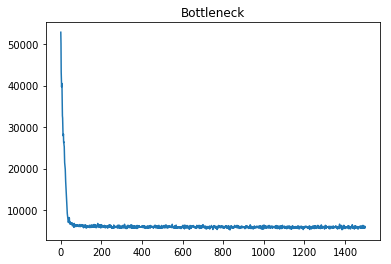

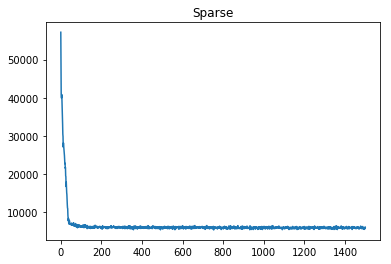

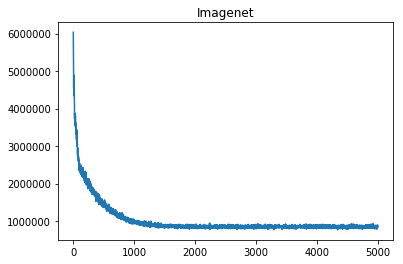

In [27]:

loss = get_losses(coll, exp_id)
loss_in = get_losses(coll_in, exp_id)
loss_sp = get_losses(coll_sp, exp_id)
# loss_mini = get_losses(coll_mini, exp_id)


# Plot the training loss

plt.figure()
plt.plot(loss)
plt.title('Bottleneck')
plt.figure()
plt.title('Sparse')
plt.plot(loss_sp)
plt.figure()
plt.title('Imagenet')
plt.plot(loss_in)



We found that all three models were able to be trained on CIFAR-10 and we were also able to train a model on imagenet. Loss functions bottomed out very suddenly with very few epochs.

### Plotting the validation results
After our train_imagenet function has evaluated the Image Net validation set for the time we can have a look at the validation results of for example exp_id='experiment_1'. Again, you need to pull the validation data from the database first. The validation data consists of the top1 and top5 accuracy that you have implemented previously. 

We have provided a function that pulls the necessary data from the database. Your task is to plot the validation curve of the top1 and top5 accuracy. Label the graphs respectively and describe what you see.

In [22]:
def get_validation_images(coll,exp_id):
    """
    Gets the validation images from the database
    """
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results'])
    last_val_i = val_steps.count()-1
    print(val_steps.count())
    pred = np.array(val_steps[last_val_i]['validation_results']['viz']['pred'])
    gt = np.array(val_steps[last_val_i]['validation_results']['viz']['gt'])
    return {'gt': gt, 'pred': pred}

def plot_validation_images(coll,exp_id, n_images = 24):
    '''
    Plots n_images images in a grid. The ground truth image is on the left 
    and the prediction is on the right.
    '''
    imgs = get_validation_images(coll,exp_id)
    fig = plt.figure(figsize=(16, 16))
    img_shape = imgs['gt'].shape[2:]
    for i in range(n_images):
        pred = imgs['pred'][i]
        plt.subplot(n_images/4,n_images/3,1 + i*2)
        plt.imshow(pred, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        gt = imgs['gt'][i]
        plt.subplot(n_images/4,n_images/3,2 + i*2)
        plt.imshow(gt, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

Validation results during training (top1 and top5) should steadily increase. Our bugged code caused training to have some odd reverse-U form.

3


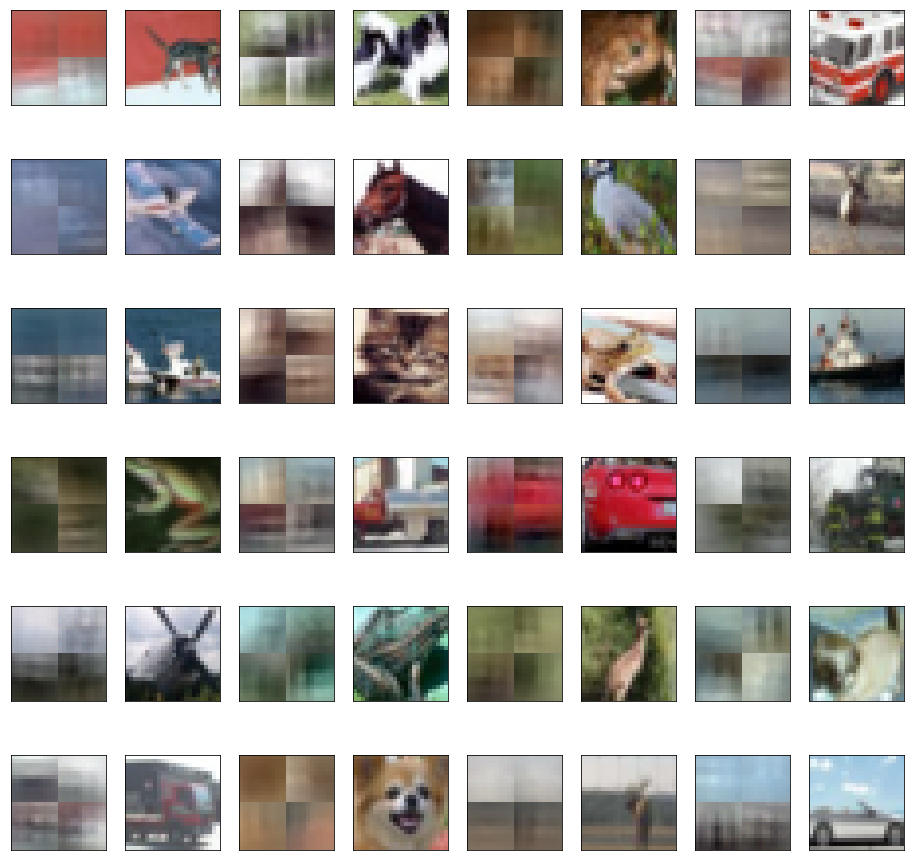

In [23]:
plot_validation_images(coll,exp_id)

## Above: shallow bottleneck model results

We found that the shallow bottleneck model produced reasonably good reconstructions given its very small number of parameters. Because it goes down to a 2x2 feature representation in the hidden layer it had very limited capacity to reconstruct the full image (hence the 2x2 gridlike artifact). In addition the model only saw a sub-part of the original image because of the 7x7 kernels but 12 stride, so it's surprising it does as well as this.

3


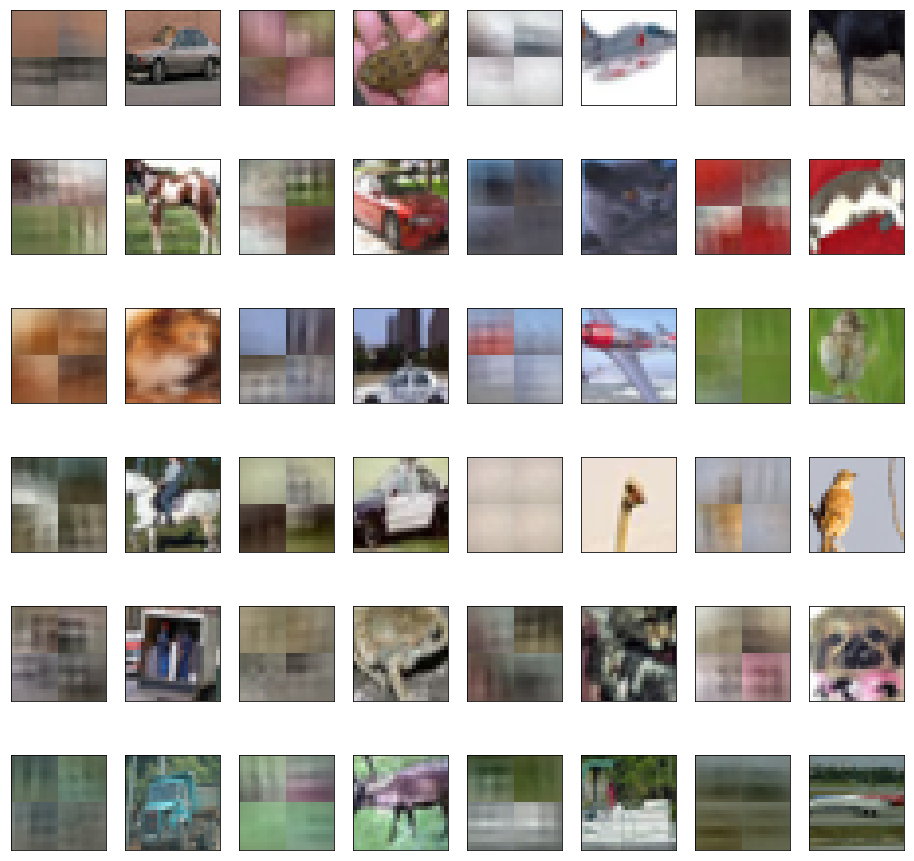

In [25]:
plot_validation_images(coll_sp, exp_id)

The sparse model recovered very similar features to the non-sparse variant

## Neural analysis
Now let's move on to fetching and displaying the computations and tests that you ran in the neural_analysis agg_func. We will first pull the data which was stored in the validation results in the database. Therefore, we call the function 'get_neural_validation_data'. The returned 'validation_data' is a list of dictionaries that contain your validation results. It's keys contain amongst others the 'exp_id' of your experiment, the evaluated 'step', and the actual 'validation_results'. In part 2 of this assignment, you should have evaluated your model at different iteration steps.

In the following, your task will be to plot your evaluations at different iteration steps. Therefore, index the data list with the appropriate indices, plot the results and mark all of the following plots with the iteration step.

In [82]:
def get_neural_validation_data(coll,exp_id):
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])
    results = [val_steps[i] for i in range(val_steps.count())]
    for res in results:
        res['step'] = coll.find({'_id': res['validates']})[0]['step']
    return results

vd = get_neural_validation_data(coll,exp_id=exp_id)
vd_sp = get_neural_validation_data(coll_sp,exp_id=exp_id)
vd_in = get_neural_validation_data(coll_in,exp_id=exp_id)
print('data keys:')
print(vd[0]['validation_results'].keys())
print(vd_sp[0]['validation_results'].keys())
print(vd_in[0]['validation_results'].keys())

data keys:
[u'V6', u'VAll']
[u'V6', u'VAll']
[u'imagenet']


In [83]:
"""
You will need to EDIT this part.
Please subselect 'validation_data' with 'idx' to pick the data entry for your desired iteration step.
1.) Assign 
    data = 'validation_data[idx]['validation_results']['valid0']'
and
    step = validation_data[idx]['step']
2.) Choose the target_layers you want to evaluate on.
"""
target_layers = ['relu']
idx = 0 ### YOUR idx HERE
data_all = vd[idx]['validation_results']['VAll']
data_6 = vd[idx]['validation_results']['V6']
step = vd[idx]['step']

data_sp_all = vd_sp[idx]['validation_results']['VAll']
data_sp_6 = vd_sp[idx]['validation_results']['V6']
step_sp = vd_sp[idx]['step']

data_in_all = vd_in[1]['validation_results']['VAll']
data_in_6 = vd_in[1]['validation_results']['V6']
step_in = vd_in[1]['step']

data_in = vd[1]['validation_results']['imagenet']
data_sp_in = vd_sp[1]['validation_results']['imagenet']
data_in_in = vd_in[0]['validation_results']['imagenet']

### Analyzing the RDM results

We will start with visualizing the RDMs you computed for each layer and the IT neurons. 

Please implement 'plot_rdms' that visualizes the rdms of all target_layers and displays the layer name as well as the spearman_corrcoef and the iteration step in the plot title.


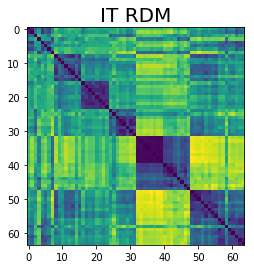

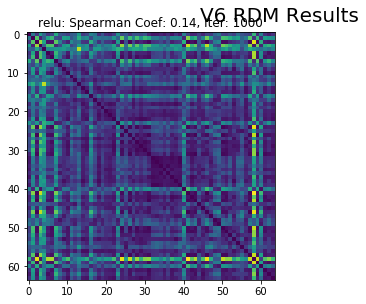

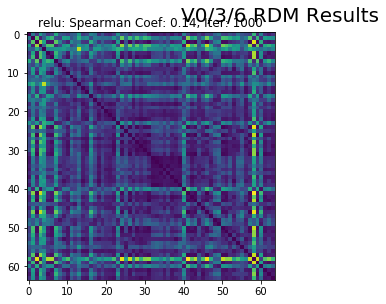

In [43]:
from math import ceil

def plot_rdms(data, target_layers, step):
    """
    Displays the RDMs of all target layers.
    
    You will need to EDIT this part. Please implement a function that visualizes 
    the rdms of all target_layers and displays the layer name as well as the 
    spearman_corrcoef in the plot title.
    """
    ncols = 2
    nrows = ceil(len(target_layers)/float(ncols))
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))
    for i, layer in enumerate(target_layers):
        rdm = data['rdm_%s' % layer]
        spearman_corrcoef = data['spearman_corrcoef_%s' % layer]
        ### YOUR CODE HERE
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(rdm)
        plt.title('%s: Spearman Coef: %.2f, Iter: %s' % (layer, spearman_corrcoef, step))
        ### END OF YOUR CODE
    plt.tight_layout()


plt.title('IT RDM', fontsize=20)
plt.imshow(data_all['rdm_it'])

plot_rdms(data_6, target_layers, step)
plt.suptitle('V6 RDM Results', fontsize=20, y=1.02)

plot_rdms(data_all, target_layers, step)
plt.suptitle('V0/3/6 RDM Results', fontsize=20, y=1.02)

We found that the RDMs generated by the shallow bottleneck autoencoder had very little correlation with the IT data. You can see a tiny bit of category structure emerging in a few spots

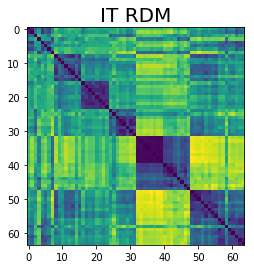

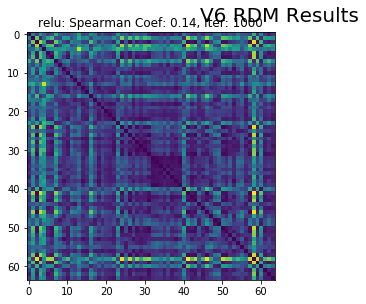

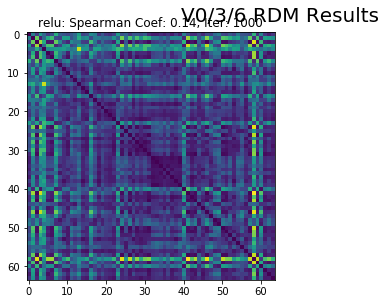

In [44]:

plt.title('IT RDM', fontsize=20)
plt.imshow(data_sp_all['rdm_it'])

plot_rdms(data_sp_6, target_layers, step)
plt.suptitle('V6 RDM Results', fontsize=20, y=1.02)

plot_rdms(data_sp_all, target_layers, step)
plt.suptitle('V0/3/6 RDM Results', fontsize=20, y=1.02)

Similar for the spare network we don't find a lot of category information in this network.


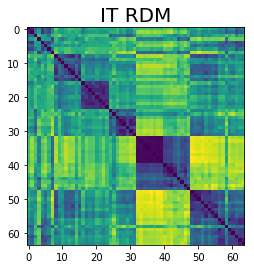

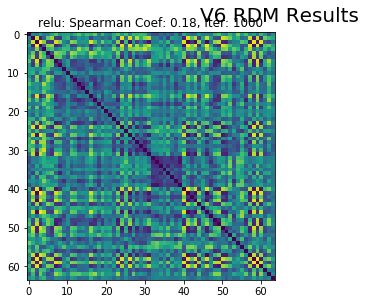

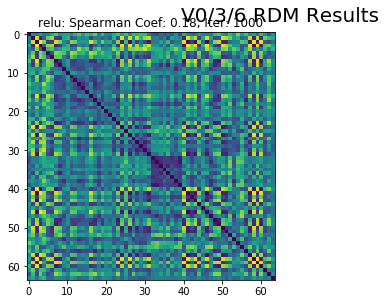

In [84]:

plt.title('IT RDM', fontsize=20)
plt.imshow(data_in_all['rdm_it'])

plot_rdms(data_in_6, target_layers, step)
plt.suptitle('V6 RDM Results', fontsize=20, y=1.02)

plot_rdms(data_in_all, target_layers, step)
plt.suptitle('V0/3/6 RDM Results', fontsize=20, y=1.02)

The imagenet trained model certainly had the most structure but it's not really clear if it has to do with categories or not. But something definitely happened differently in the training of this model!

### Analyzing the categorization results

Now let's visualize the results of the categorization test we performed for each layer. 

Your task is to plot the confusion matrix 'cms' across all categorized classes for each layer. You will need 'cms', 'labelset' and 'accbal' from data['categorization_"insert_target_layer_here"']['result_summary']. Label the x and y axis with 'labelset'. Put the layer name, average accuracy and the iteration step in the plot title. To get the average accuracy substract 0.5 from the mean of 'accbal' and multiply the result with 2. Describe what you see.

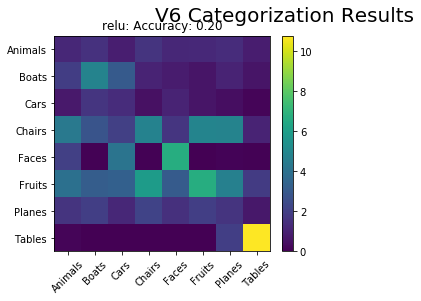

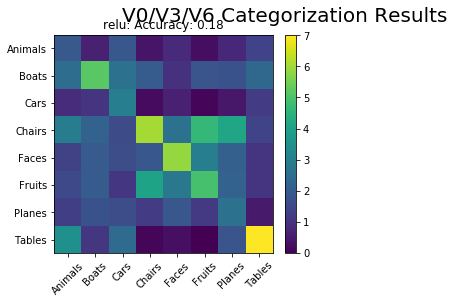

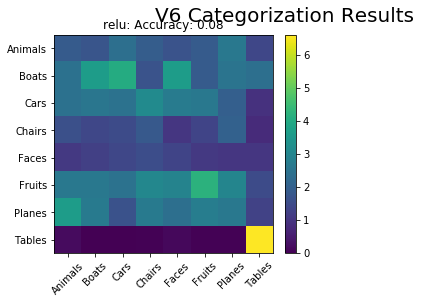

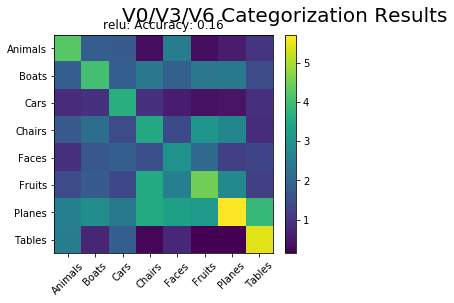

In [59]:
def plot_categorization_results(data, target_layers, step):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    ncols = 2
    nrows = 1
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))

    for i, layer in enumerate(target_layers):
        k = 'categorization_%s' % layer
        categorization_results = data[k]['result_summary']
        ### YOUR CODE HERE
        confusion = np.vstack([np.mean(performance, 1) for performance in categorization_results['cms']])
        acc = (np.mean(categorization_results['accbal'])-.5)*2 # why this?
        # plot
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(confusion)
        plt.xticks(range(8), categorization_results['labelset'], rotation=45)
        plt.yticks(range(8), categorization_results['labelset'])
        plt.colorbar(fraction=.045)
        plt.title('%s: Accuracy: %.2f' % (layer, acc))
        ### END OF YOUR CODE
    plt.tight_layout()
        
plot_categorization_results(data_6, target_layers, step,)
plt.suptitle('V6 Categorization Results', fontsize=20, y=1.02)
plot_categorization_results(data_all, target_layers, step)
plt.suptitle('V0/V3/V6 Categorization Results', fontsize=20, y=1.02)

plot_categorization_results(data_sp_6, target_layers, step,)
plt.suptitle('V6 Categorization Results', fontsize=20, y=1.02)
plot_categorization_results(data_sp_all, target_layers, step)
plt.suptitle('V0/V3/V6 Categorization Results', fontsize=20, y=1.02)

Across categories we didn't see good categorization--looks like the simple model doesn't have nearly enough feature information to perform. This is especially apparent in the V6 conditions in which categorization was entirely impossible.

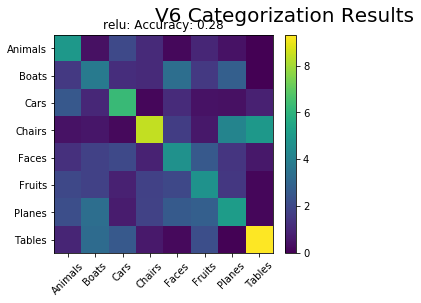

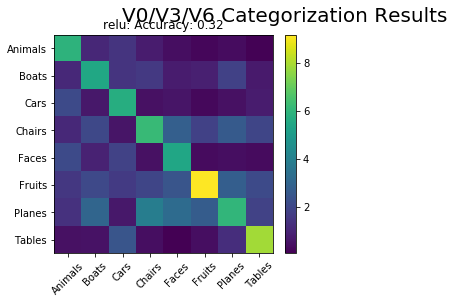

In [85]:

plot_categorization_results(data_in_6, target_layers, step,)
plt.suptitle('V6 Categorization Results', fontsize=20, y=1.02)
plot_categorization_results(data_in_all, target_layers, step)
plt.suptitle('V0/V3/V6 Categorization Results', fontsize=20, y=1.02)

The imagenet model in comparison to the others does far better at categorization -- you can slightly see the categorization structure appearing for both high variation and the all conditions. Clearly training on imagenet helps a lot with building category features.

### Analyzing the within categorization reuslts

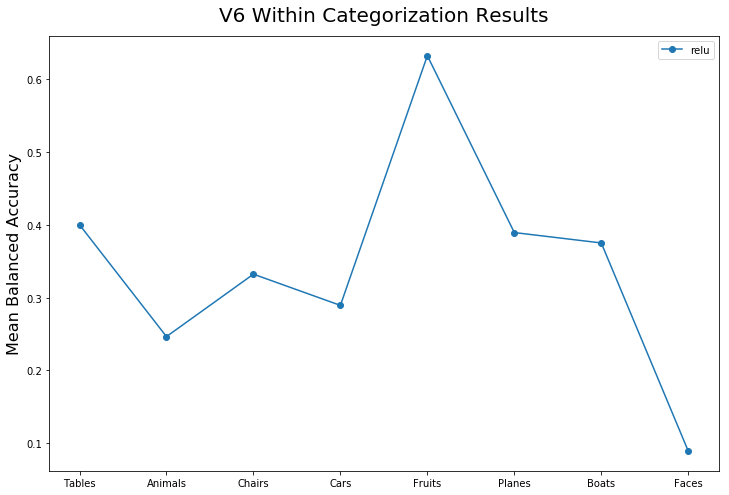

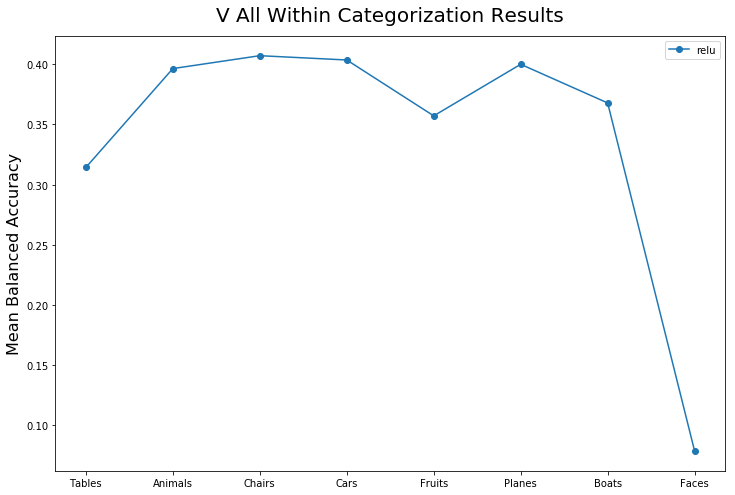

In [48]:
def plot_within_categorization_results(data, target_layers):
    plt.figure(figsize=(12,8))
    for i, layer in enumerate(target_layers):
        layer_results = data['within_categorization_%s' % layer]
        performance = [(k, (np.mean(v['result_summary']['accbal'])-.5)*2) for k,v in layer_results.items()]
        plt.plot([i[1] for i in performance], '-o', label=layer)
    plt.xticks(range(len(performance)), [i[0] for i in performance])
    plt.ylabel('Mean Balanced Accuracy', fontsize=16)
    plt.legend()
    
plot_within_categorization_results(data_6, target_layers)
plt.title('V6 Within Categorization Results', fontsize=20, y=1.02)

plot_within_categorization_results(data_all, target_layers)
plt.title('V All Within Categorization Results', fontsize=20, y=1.02)


The non-sparse variant was actually able to do some categorization within object categories, except for faces. Perhaps this latter observation has to do with how similar faces are? 

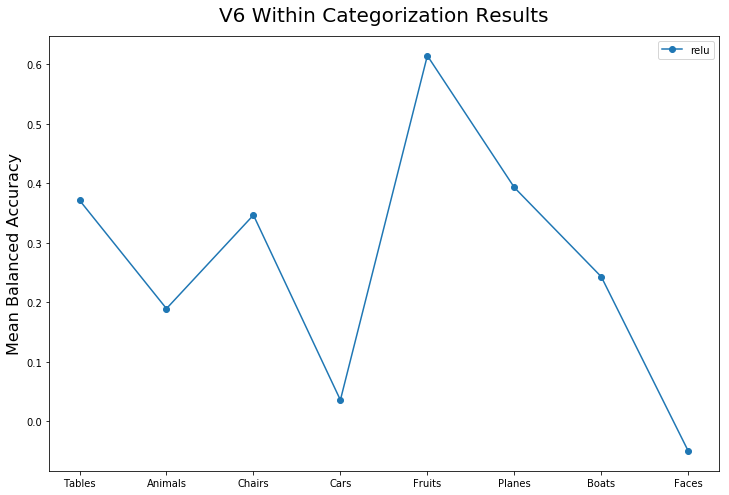

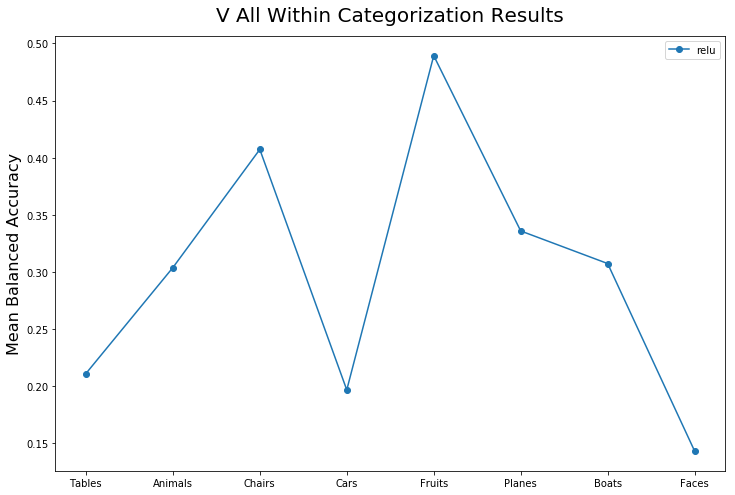

In [49]:

plot_within_categorization_results(data_sp_6, target_layers)
plt.title('V6 Within Categorization Results', fontsize=20, y=1.02)

plot_within_categorization_results(data_sp_all, target_layers)
plt.title('V All Within Categorization Results', fontsize=20, y=1.02)

Sparse model does a bit worse than the non-sparse version.

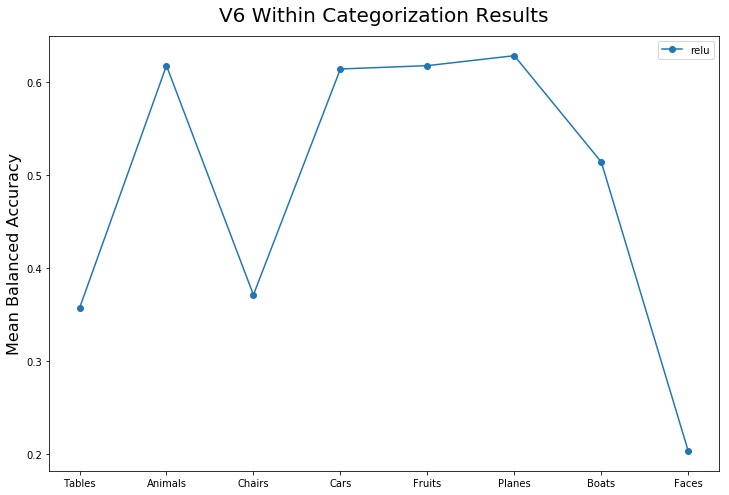

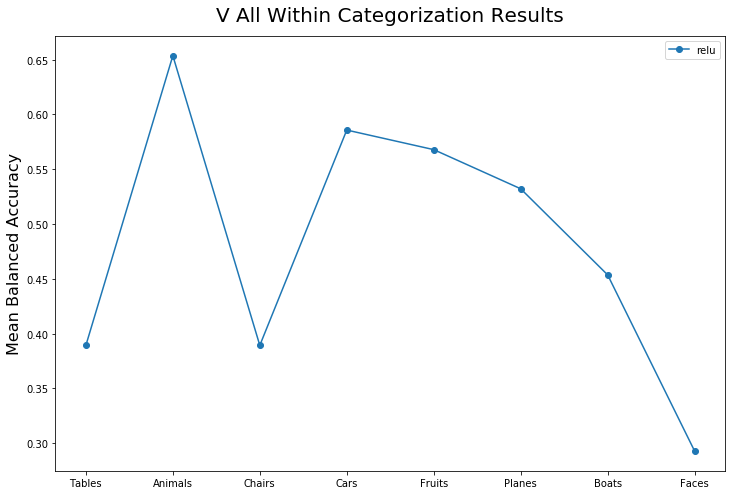

In [86]:

plot_within_categorization_results(data_in_6, target_layers)
plt.title('V6 Within Categorization Results', fontsize=20, y=1.02)

plot_within_categorization_results(data_in_all, target_layers)
plt.title('V All Within Categorization Results', fontsize=20, y=1.02)


The imagenet trained variant of the model faired far better than the others getting accuracies above chance on the faces and achieving much higher overall categorizaiton accuracy. 

### Analyzing the regression results

We will now display the results of the regression test. 

Please print (1 - data['it\_regression_"insert_target_layer_here"']['noise_corrected_multi_rsquared_loss']) for each layer and step and label the print out with the layer name and step. Describe what you observe.

In [89]:
def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    
    You will need to EDIT this function.
    """
    for layer in target_layers:
        k = 'it_regression_%s' % layer
        regression_results = data[k]
        ### YOUR CODE HERE
        performance = 1-regression_results['noise_corrected_multi_rsquared_loss']
        print('layer: %s, step: %s, performance: %.2f' % (layer, step, performance))
        ### END OF YOUR CODE
        
print('********** V 6 *********************')
plot_regression_results(data_6, target_layers, step)
plot_regression_results(data_all, target_layers, step)
print('\n********** Sparse ******************')
plot_regression_results(data_sp_6, target_layers, step)
plot_regression_results(data_sp_all, target_layers, step)
print('\n********** Imagenet trained ******************')
plot_regression_results(data_in_all, target_layers, step)
plot_regression_results(data_in_6, target_layers, step)

********** V 6 *********************
layer: relu, step: 1000, performance: -0.01
layer: relu, step: 1000, performance: 0.01

********** Sparse ******************
layer: relu, step: 1000, performance: -0.01
layer: relu, step: 1000, performance: 0.01

********** Imagenet trained ******************
layer: relu, step: 1000, performance: 0.02
layer: relu, step: 1000, performance: -0.01


The autoencoder wasn't able to successfully do regression in any case. 

In [72]:

def plot_imagenet_results(data, target_layers, step):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    for i, layer in enumerate(target_layers):
        k = 'imagenet_%s' % layer
        categorization_results = data[k]['result_summary']
        ### YOUR CODE HERE
        labels = categorization_results['labelset']
        acc = 2*(np.mean(categorization_results['accbal'])-0.5)
        print('{name}: avg_accuracy: {acc:.5f}; step: {step}'.format(
            name=layer,
            acc=acc,
            step=step,
        ))
    

In [91]:
print('Shallow bottleneck:')
plot_imagenet_results(data_in, target_layers, step)
print('Shallow bottleneck (with sparsity):')

plot_imagenet_results(data_sp_in, target_layers, step)
print('Shallow bottleneck (trained on ImageNet):')

plot_imagenet_results(data_in_in, target_layers, step)

Shallow bottleneck:
relu: avg_accuracy: 0.06061; step: 1000
Shallow bottleneck (with sparsity):
relu: avg_accuracy: 0.03636; step: 1000
Shallow bottleneck (trained on ImageNet):
relu: avg_accuracy: 0.03300; step: 1000


On the imagenet classificaiton task we found that neither of the bottleneck autoencoders did well. The sparse version appears to have suffered from the sparsity constraints.

Curiously the model trained on imagenet itself didn't perform any better than the other two. In the end this is almost certainly because the model fails to have actual object category representations and really only encodes color and a bit of texture information.

### Visualizing the conv1 kernels
Lastly, we will plot the conv1 filter kernels. 

Your task is to visualize the 'conv1_kernel' in a 12 x 8 grid. Therefore, you just have to plot each kernel as an image in a subplot. The kernels are stored in data['conv1_kernel']. Print out the iteration step and plot the kernels and describe what you see.

In [50]:
def plot_conv1_kernels(data, step):
    """
    Plots the 96 conv1 kernels in a 12 x 8 subplot grid.
    
    You will need to EDIT this function.
    """
    print('Iteration step: %d' % step)
    kernels = np.array(data['conv_kernel'])
    ### YOUR CODE HERE
    xc = 0
    yc = 0
    ncols = 12
    nrows = 8
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))
    for kernelID in range(kernels.shape[3]):
        kernel = kernels[:,:,:,kernelID]
        plt.subplot(nrows, ncols, kernelID+1)
        plt.imshow(kernel)
    plt.tight_layout()
    ### END OF YOUR CODE
           

Iteration step: 1000


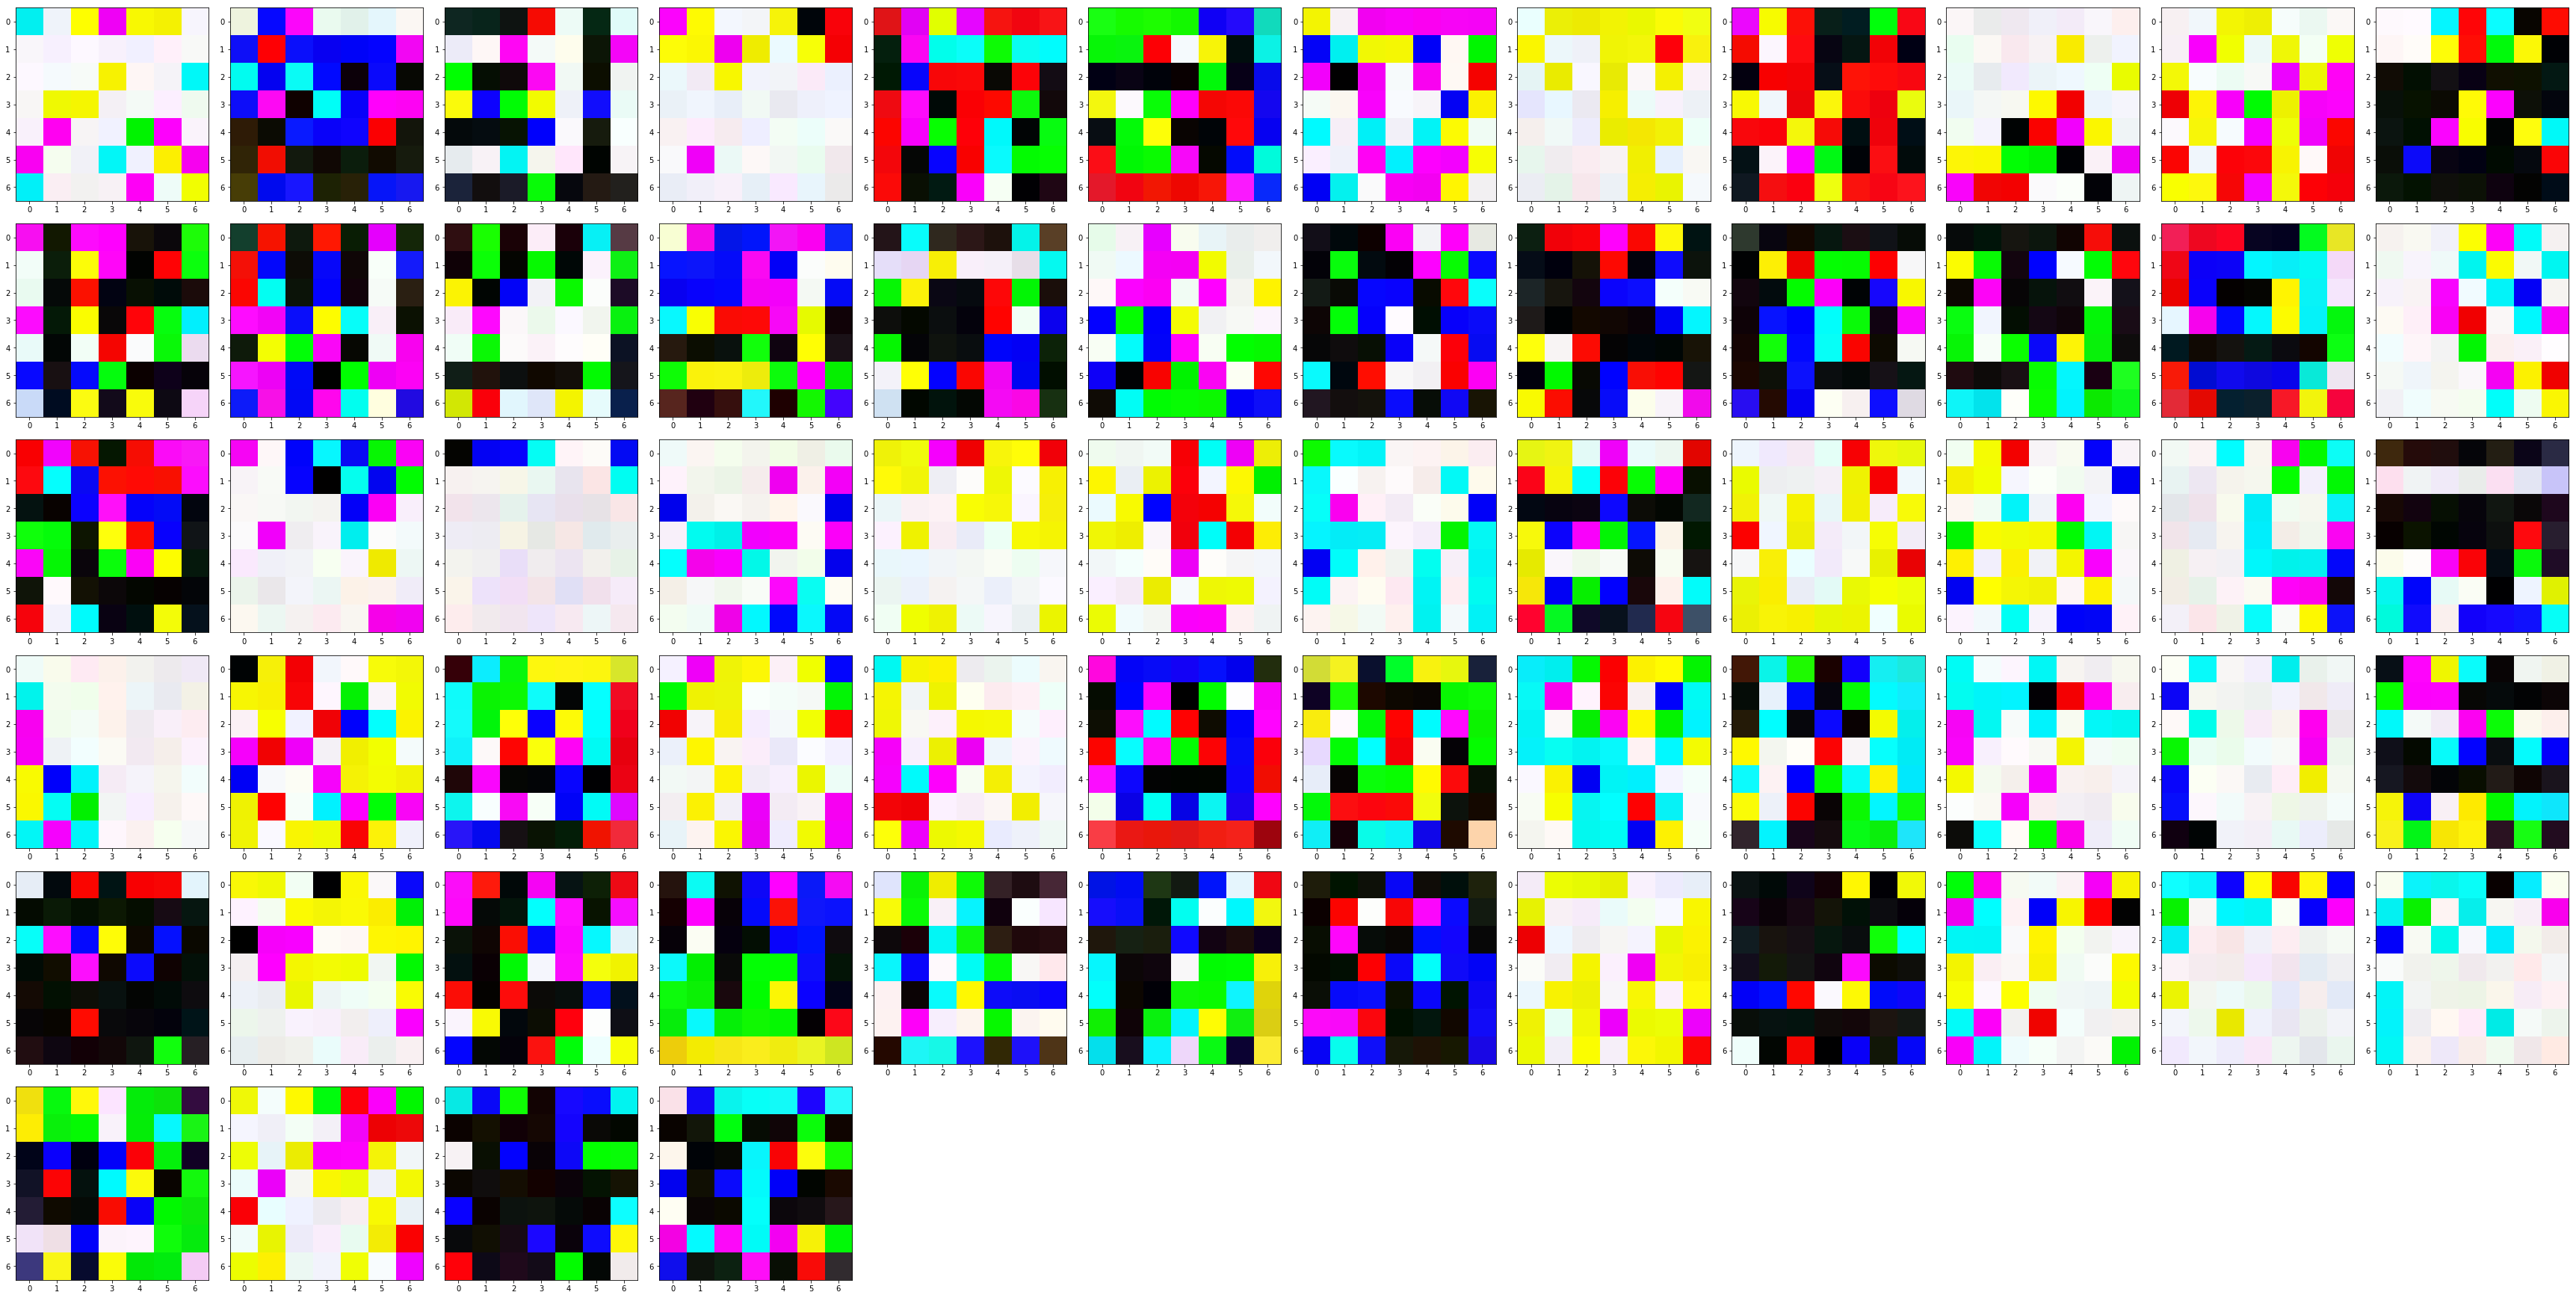

In [51]:
plot_conv1_kernels(data_all, step)

The kernels from our shallow bottleneck autoencoder don't look like much. We see selectivity for some colors and perhaps some slightly gabor like structure, but they are mostly maxed out at full pixel values. Not sure why this is the case.

Iteration step: 1000


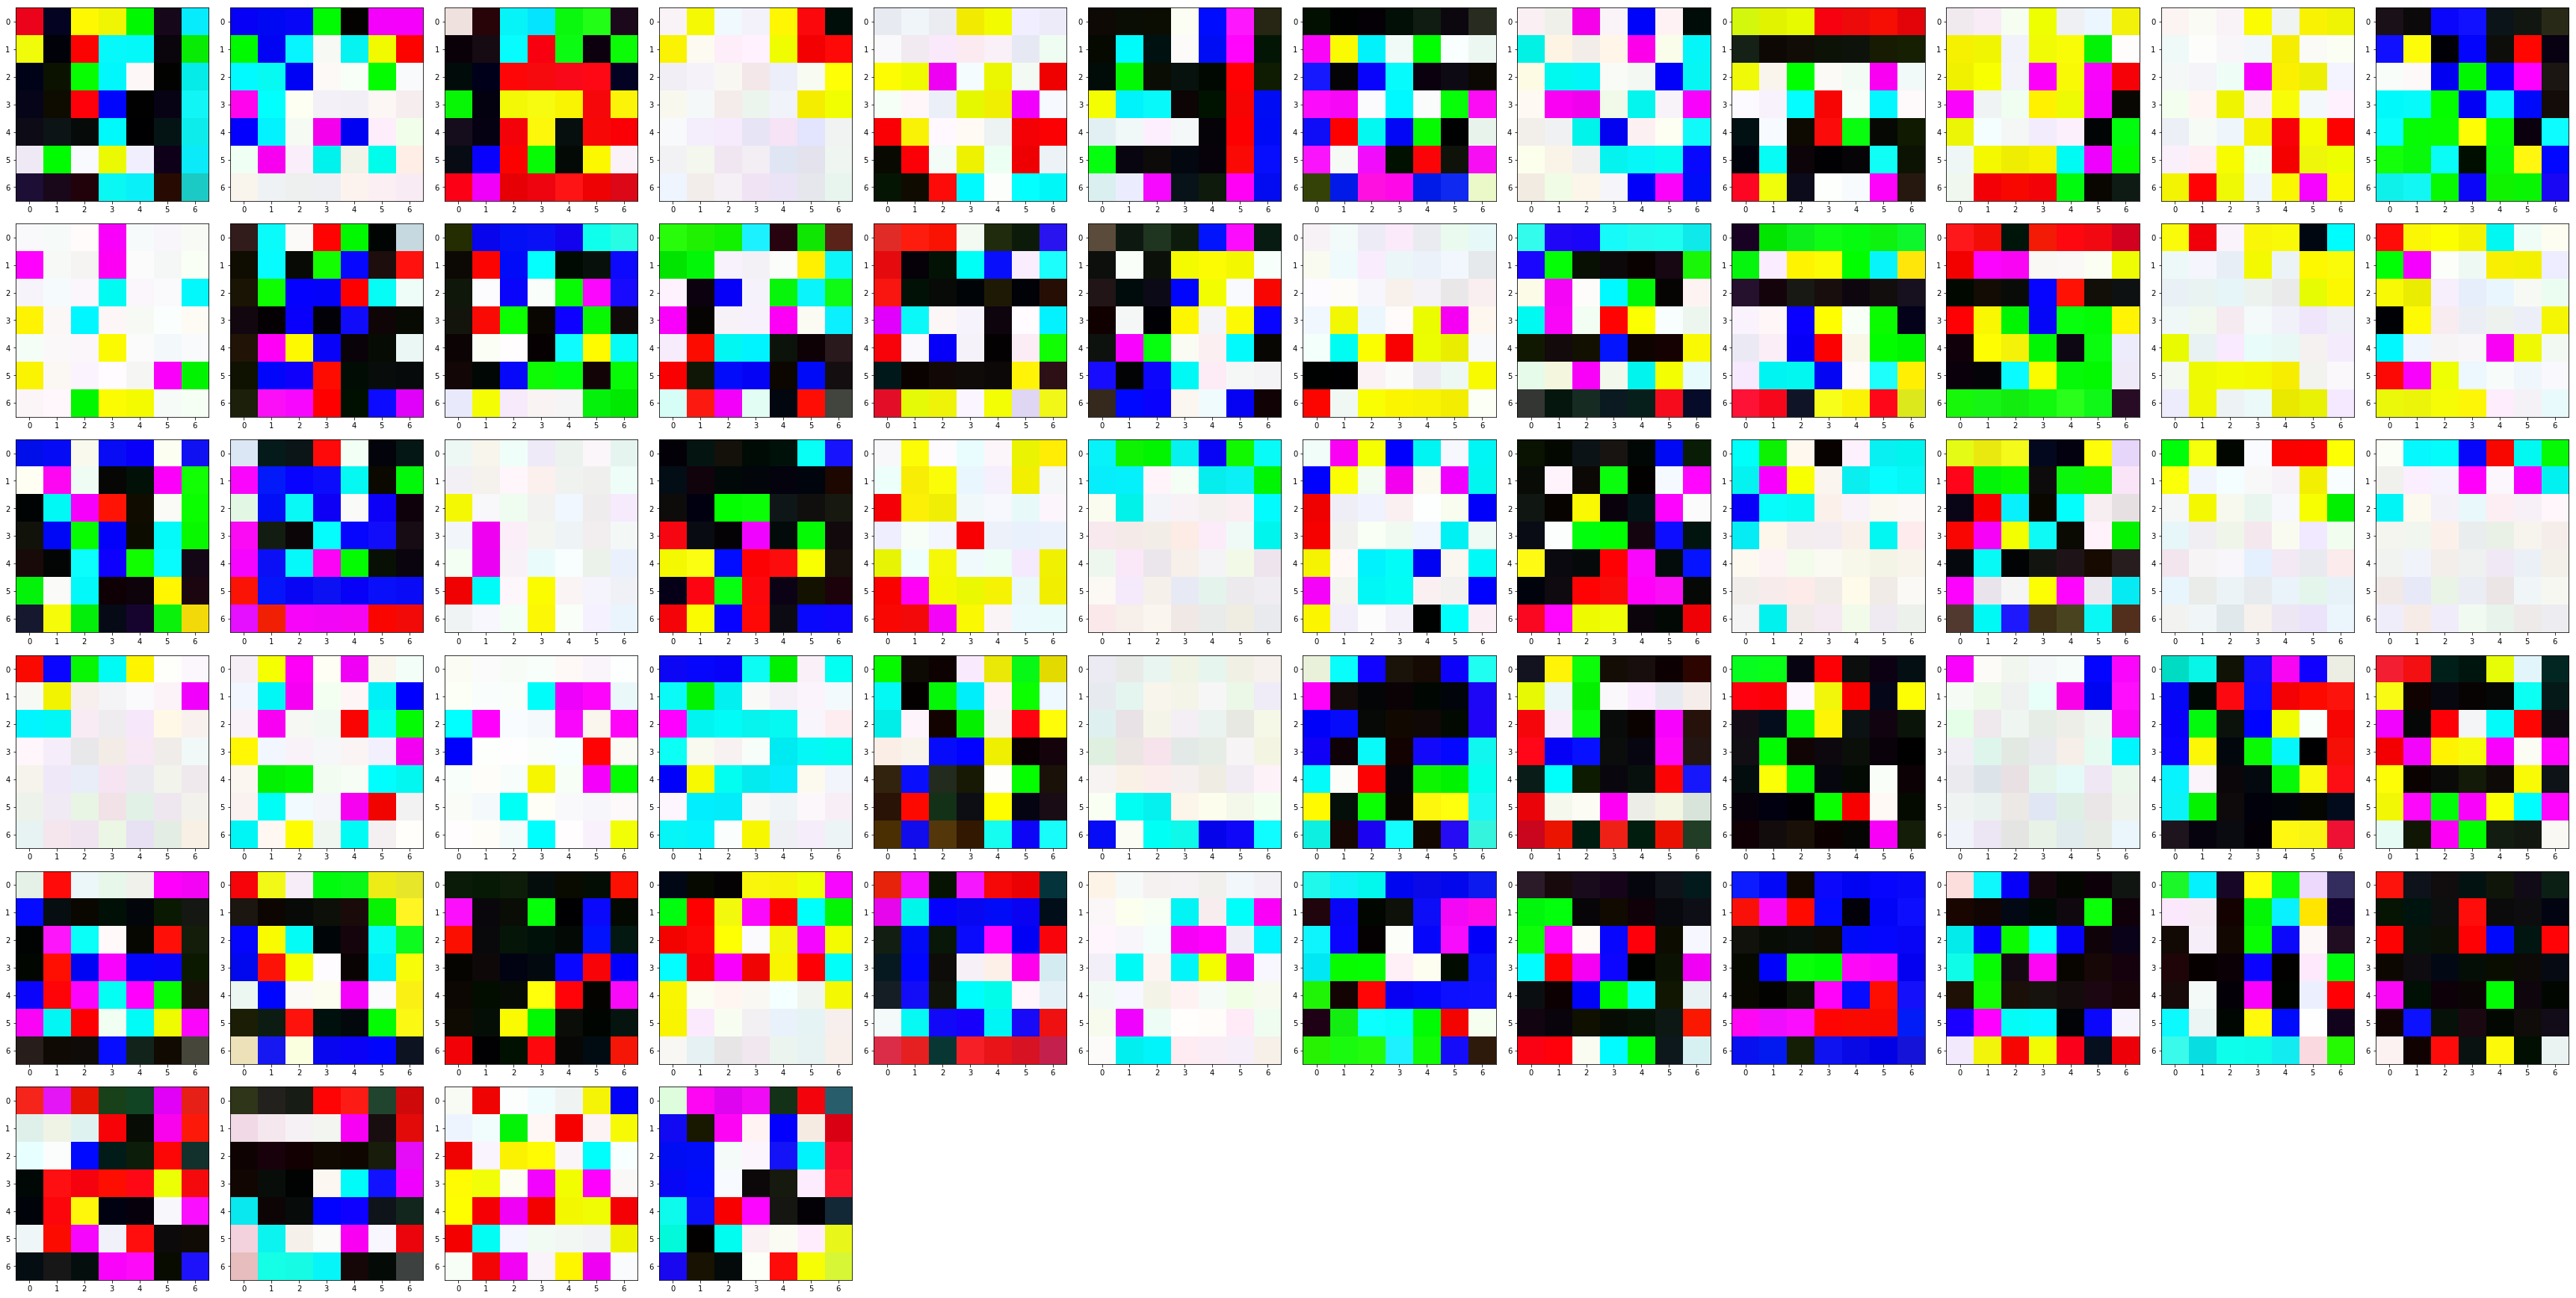

In [52]:
plot_conv1_kernels(data_sp_all, step)

We found similar results for the sparse variant.

Iteration step: 1000


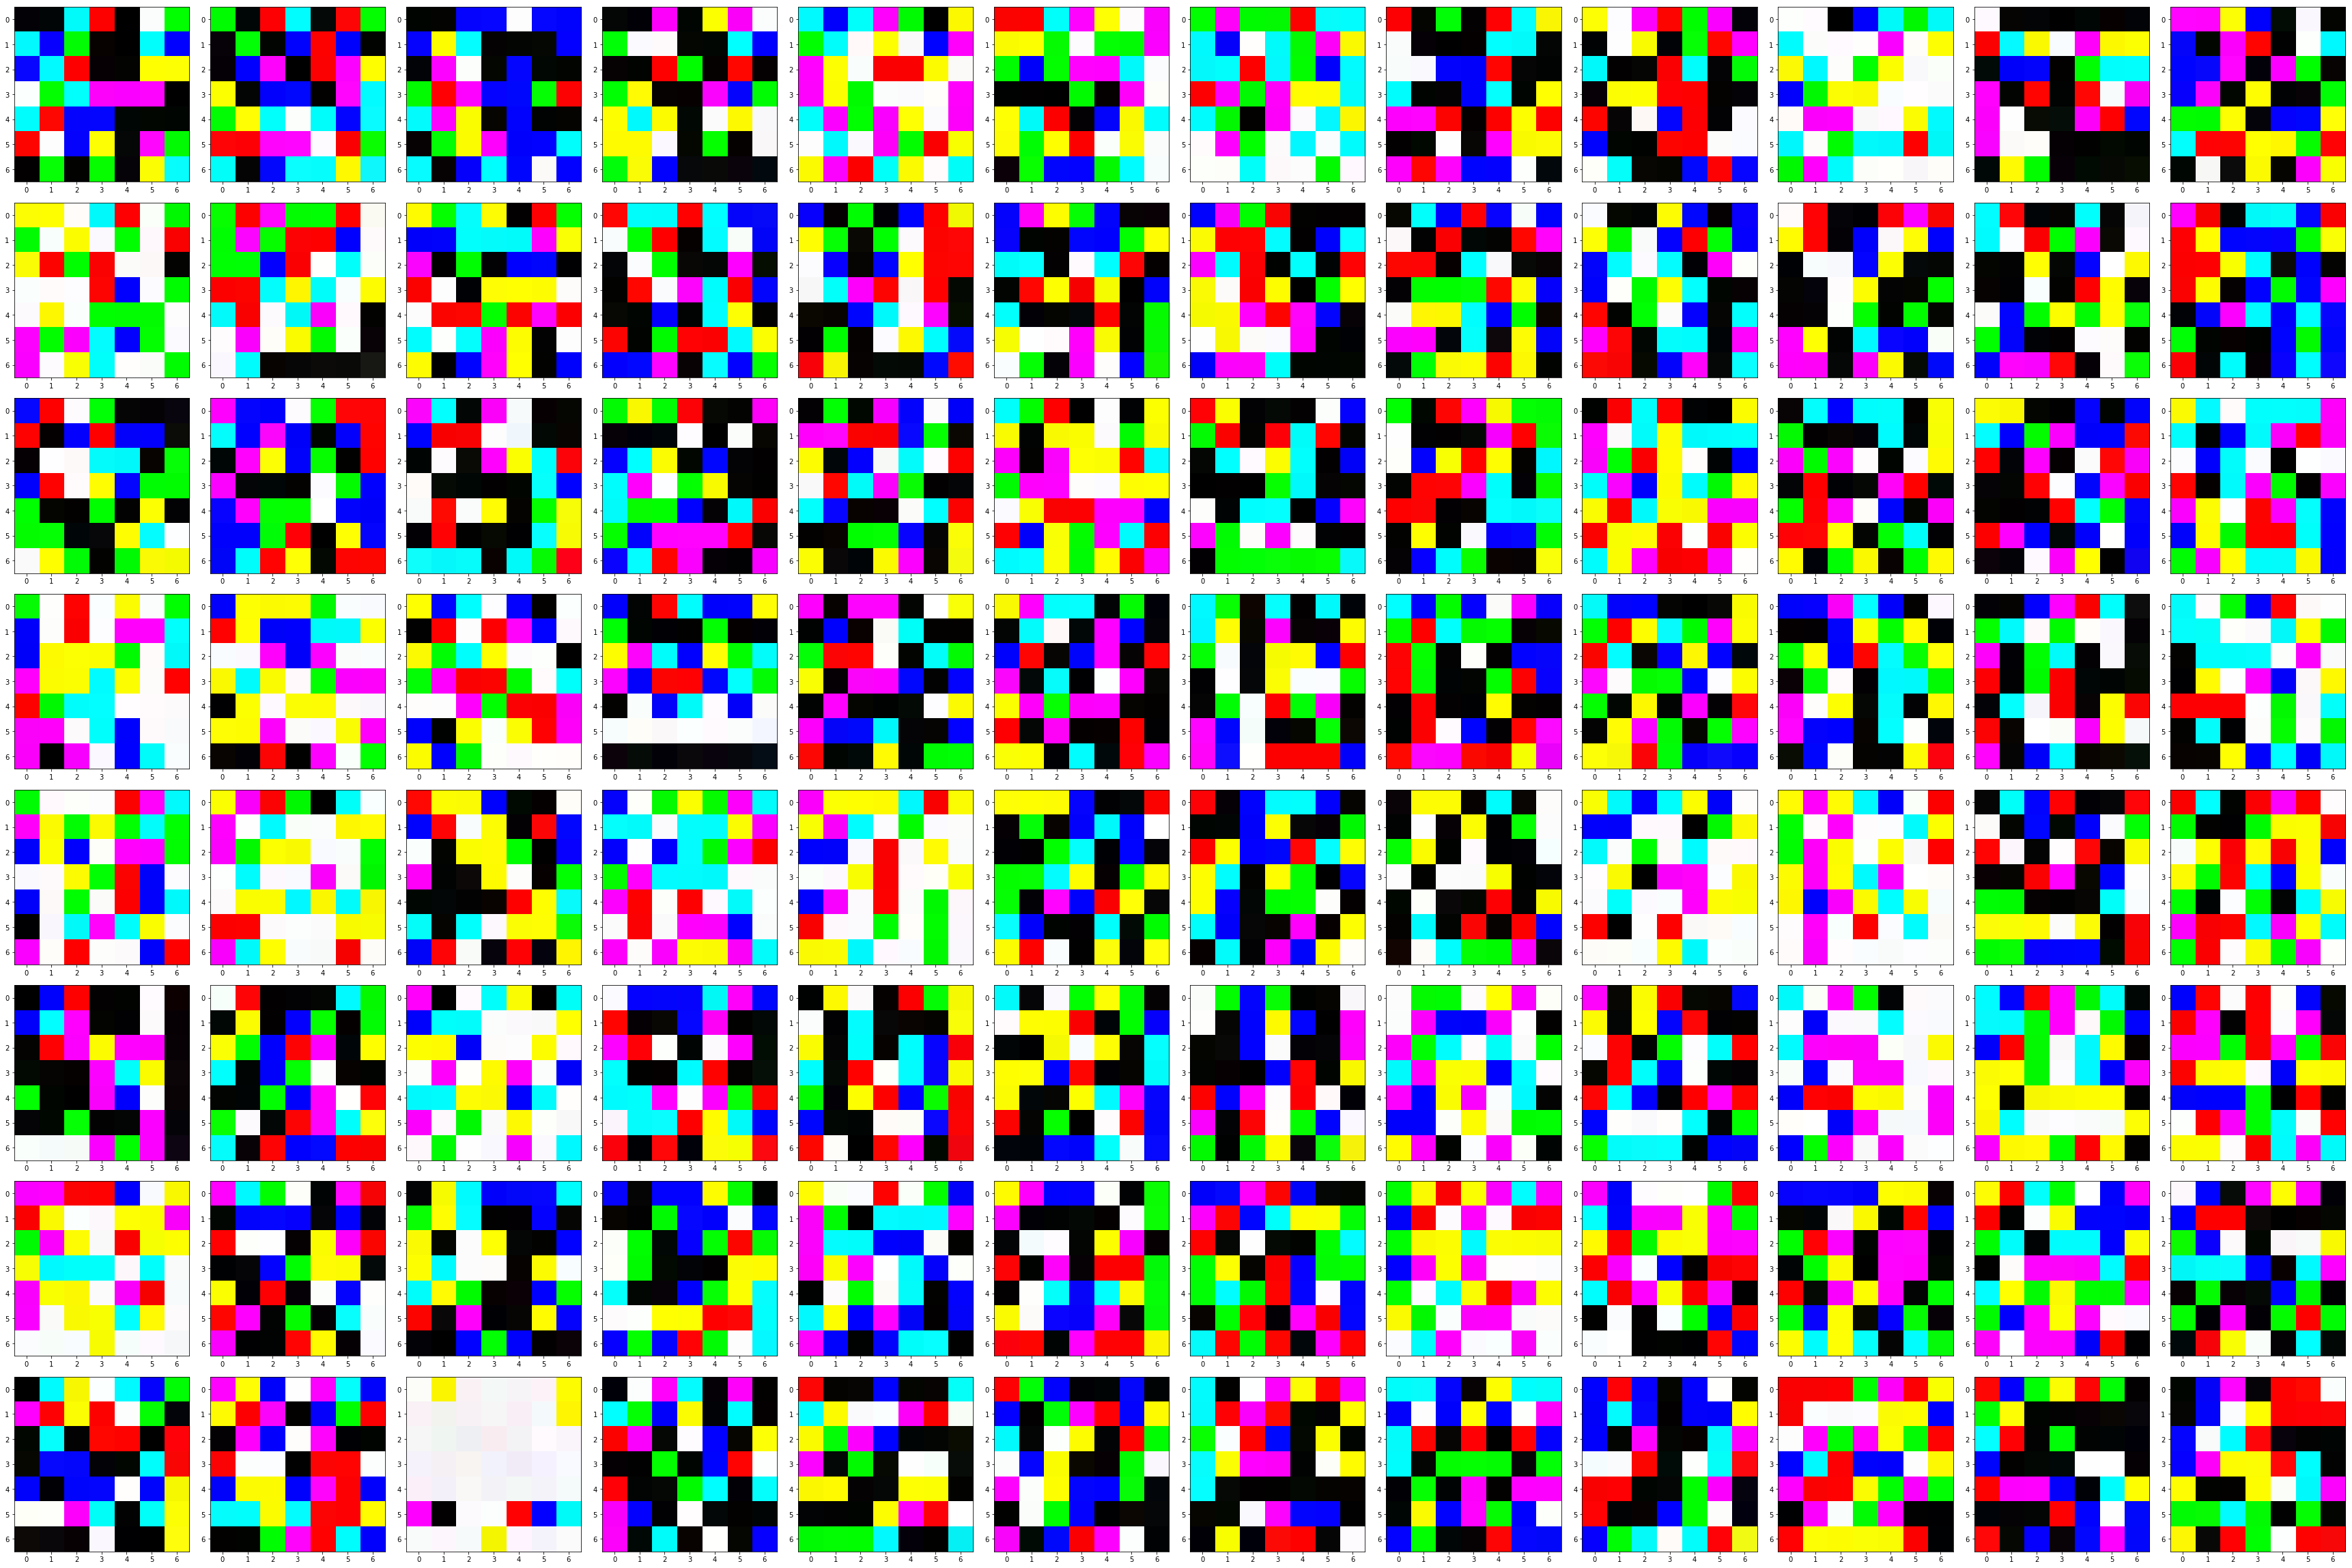

In [94]:
def plot_conv1_kernels(data, step):
    """
    Plots the 96 conv1 kernels in a 12 x 8 subplot grid.
    
    You will need to EDIT this function.
    """
    print('Iteration step: %d' % step)
    kernels = np.array(data['conv_kernel'])
    ### YOUR CODE HERE
    xc = 0
    yc = 0
    ncols = 12
    nrows = 8
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))
    for kernelID in range(96):
        kernel = kernels[:,:,:,kernelID]
        plt.subplot(nrows, ncols, kernelID+1)
        plt.imshow(kernel)
    plt.tight_layout()
    ### END OF YOUR CODE
    
plot_conv1_kernels(data_in_all, step)

Like the other kernels we found very little structure in the autoencoder kernels and they appear to mostly be maxing out the RGB values.